# 基于Tensorflow的交通标志识别

## 项目背景

    交通标志是道路基础设施的重要组成部分，它们为道路使用者提供了一些关键信息，并要求驾驶员及时调整驾驶行为，以确保遵守道路安全规定。如果没有交通标志，可能会发生更多的事故，因为司机无法获知最高安全速度是多少，不了解道路状况，比如急转弯、学校路口等等。

    现如今，自动驾驶车辆已经进入人们的视线，未来他必将应用于人们的生活。当然，自动驾驶车辆也必须遵守交通法规，因此车辆也需要识别和理解不同的交通标志。而传统标准大的计算机视觉的方法来对交通标志进行检测和分类会耗费相当多的时间在处理图像的重要特征上，所以我们采用深度学习的架构，来让机器完成对交通标志的识别和学习。

## 交通标志分类

    先从最简单的目标开始：分类。对于给定的交通标志的图像，我们所构建的模型应该能够显示其对应的类型（停车标志，速度限制，产量标志等）。由于数据集中的图像内容不同，我们将处理正确裁剪的图像，使得交通标志占据大部分图像。

## 导入

In [ ]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from datetime import timedelta
import warnings

# Allow image embeding in notebook
%matplotlib inline

## 数据集准备

    从网络上搜索并下载“交通标志数据集”，对应的数据集应为两类，即训练集和测试集。我们将两个数据集放在：
    /traffic/datasets/BelgiumTS/Training/
    /traffic/datasets/BelgiumTS/Testing/
    上面的两个目录中的每一个都含有62个子目录，从00000到00062顺序命名。目录名称代表代码（或标签），目录中的图像是该标签的交通标志的示例。

## 解析并加载训练数据集

    Training 目录包含子目录，其序列号为00000到00061.目录名称表示0到61之间的标签，每个目录中的图像代表属于该标签的交通标志。 图像以不常见的.ppm格式保存，但幸运的是，skimage库支持这种格式。

In [35]:
def load_data(data_dir):
    """Loads a data set and returns two lists:

    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "./"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

## 探索数据集

In [36]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


    显示每个标签中的第一幅图像。目的是为了按顺序的显示每个标签所表示的交通标志。

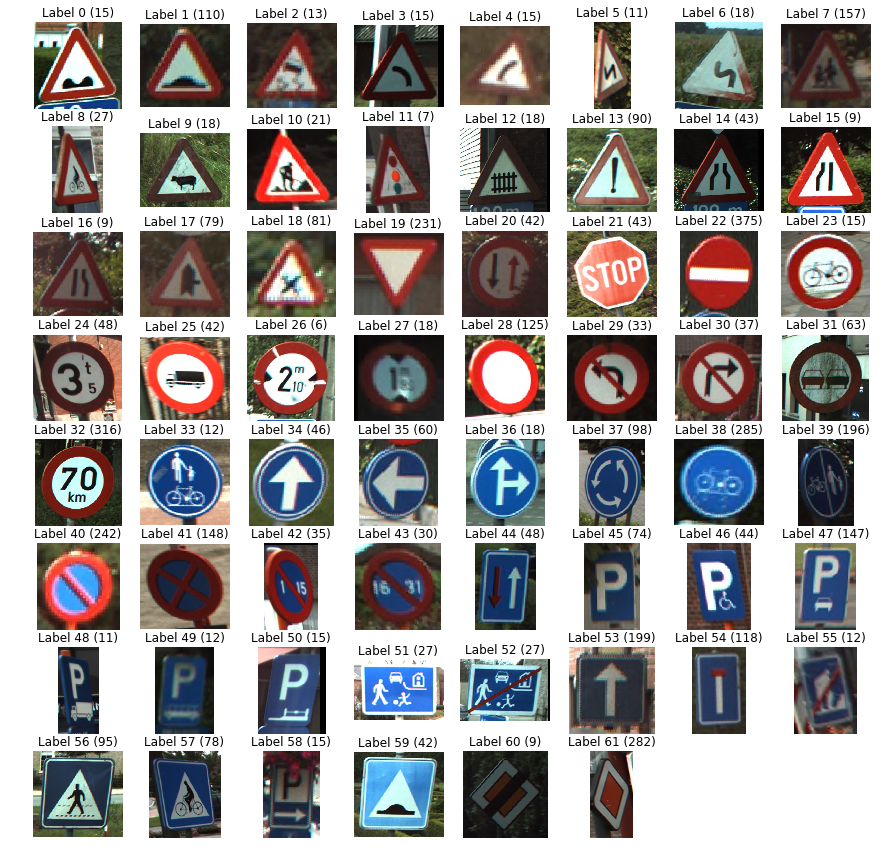

In [37]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

    以上所显示的就是62个交通标志的图像。每个交通标志都占据了图像的大部分区域，这也方便了后续的工作：不用重新在图像中寻找标志。但美中不足的是，上述的图片具有着不同的宽高比，而简单神经网络是采用固定大小的深入，所以我们需要进行一些预处理。首先我们先选择一个标签并查看更多该标签下的图像。我们选择标签32：

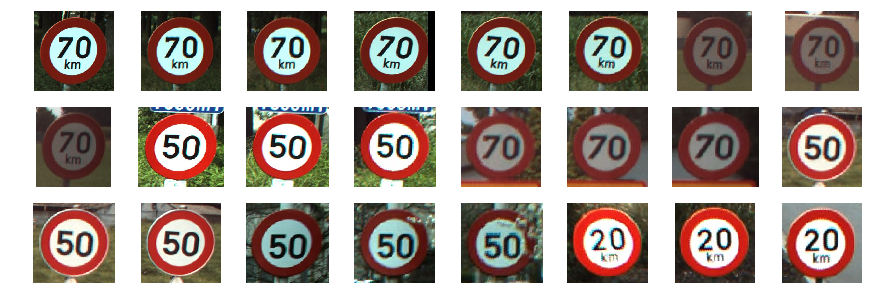

In [38]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

    我们可发现上述输出的所有图像均为超速限制标志，但对应的超速限制的数字却不同。由此可见，该数据集认为所有的超速限制标志都属于同一类，无论数字为多少。根据以上的方法检查其他的标签，确保该数据没有混淆不同类别的交通标志。例如标签26和27，这两类和标签32类似，它们也有红色圆圈，我们检查的目的就是为了确保红色圆圈内的数字不同，使得之后构建的模型能够准确有效的区分各类标签。

## 处理不同尺寸的图片

    大多数图片分类的神经网络需要固定输入的大小，我们的第一个模型也会做到这一点。所以，我们需要将所有图片调整为相同的大小。一种常见的方法是将图像裁剪并填充到选定的比例，但是我们必须确保在此过程中不切断部分交通标志。 这似乎可能需要手动工作！ 让我们做一个更简单的解决方案（真正的黑客）：我们只需将图像调整为固定大小，并忽略由不同宽高比引起的扭曲。 一个人即使被压缩或拉伸一点也能轻易识别出交通标志，所以我们希望我们构造的模型也可以。

    到底我们的图像尺寸有多大呢？

In [39]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


    我们可以看到图像的尺寸大都在128x128左右。我们将其调整为32被，即将数据和模型大小减少16倍。而且32x32可能仍然足以识别这些图像。同时打印数据最小值和最大值，来确定数据范围，同时验证数据尽早发现错误。

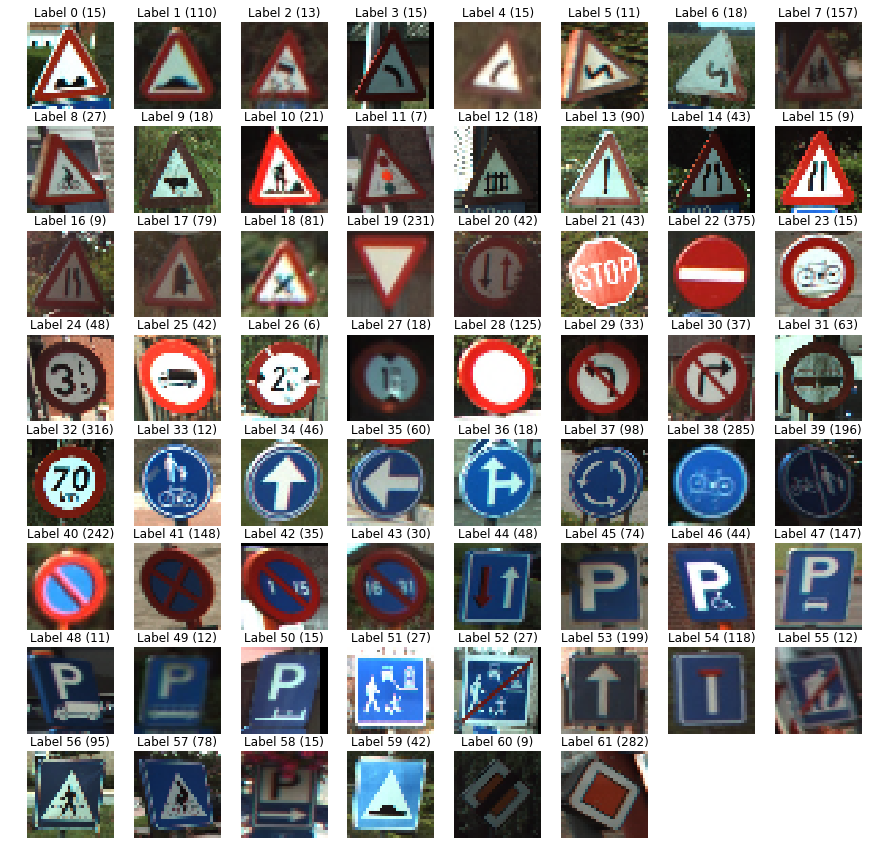

In [40]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

    打印32x32的图像如上。可以看到32x32图像并不那么清晰，但仍然可识别。值得注意的是，上面的显示会显示大于实际大小的图像，因为matplotlib库会尝试将它们与网格大小相匹配。 让我们打印一些图像的大小来验证我们是否正确。

In [41]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0073912377450982, max: 1.0
shape: (32, 32, 3), min: 0.003576899509804572, max: 1.0
shape: (32, 32, 3), min: 0.0015567555147058805, max: 1.0
shape: (32, 32, 3), min: 0.056774662990195915, max: 0.969267003676469
shape: (32, 32, 3), min: 0.026654411764708223, max: 0.9895220588235292


    尺寸是正确的。 但要检查最小值和最大值！ 它们现在的范围从0到1.0，这与我们在上面看到的0-255范围不同。 调整大小功能为我们做了转变。 将值归一化到0.0-1.0的范围是非常常见的，所以我们会保留它。

# 创建模型

## 构建Tensorflow图

 输入图像在第一层卷积层里使用权重过滤器处理。结果在16张新图里，每张代表了卷积层里一个过滤器（的处理结果）。图像经过降采样，分辨率从28x28减少到14x14。

16张小图在第二个卷积层中处理。这16个通道以及这层输出的每个通道都需要一个过滤权重。总共有36个输出，所以在第二个卷积层有16 x 36 = 576个滤波器。输出图再一次降采样到7x7个像素。

第二个卷积层的输出是36张7x7像素的图像。它们被转换到一个长为7 x 7 x 36 = 1764的向量中去，它作为一个有128个神经元（或元素）的全连接网络的输入。这些又输入到另一个有10个神经元的全连接层中，每个神经元代表一个类别，用来确定图像的类别，即图像上的数字。

卷积滤波一开始是随机挑选的，因此分类也是随机完成的。根据交叉熵（cross-entropy）来测量输入图预测值和真实类别间的错误。然后优化器用链式法则自动地将这个误差在卷积网络中传递，更新滤波权重来提升分类质量。这个过程迭代了几千次，直到分类误差足够低。

这些特定的滤波权重和中间图像是一个优化结果，和你执行代码所看到的可能会有所不同。

注意，这些在TensorFlow上的计算是在一部分图像上执行，而非单独的一张图，这使得计算更有效。也意味着在TensorFlow上实现时，这个流程图实际上会有更多的数据维度。

In [42]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


##  神经网络的配置

方便起见，在这里定义神经网络的配置，你可以很容易找到或改变这些数值，然后重新运行Notebook。

In [43]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## 数据维度

在下面的源码中，有很多地方用到了数据维度。它们只在一个地方定义，因此我们可以在代码中使用这些数字而不是直接写数字。

In [44]:
# We know that traffic images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 62

## 创建帮助函数

### 创建新变量的帮助函数

In [45]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

### 创建卷积层的帮助函数

这个函数为TensorFlow在计算图里创建了新的卷积层。这里并没有执行什么计算，只是在TensorFlow图里添加了数学公式。

假设输入的是四维的张量，各个维度如下：
1.图像数量
2.每张图像的Y轴
3.每张图像的X轴
4.每张图像的通道数

输入通道可能是彩色通道，当输入是前面的卷积层生成的时候，它也可能是滤波通道。

输出是另外一个4通道的张量，如下：
1.图像数量，与输入相同
2.每张图像的Y轴。如果用到了2x2的池化，是输入图像宽高的一半。
3.每张图像的X轴。同上。
4.卷积滤波生成的通道数。


In [46]:
def new_conv_layer(input,
                   num_input_channels,  #输入层的通道数
                   filter_size,         #每个过滤器的宽度和高度
                   num_filters,         #卷积层数量
                   use_pooling = True): #2*2滤波器
    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size,filter_size,num_input_channels,num_filters]
    
    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
    
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input = input,
                         filter = weights,
                         strides=[1,1,1,1],
                         padding= 'SAME')
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize = [1,2,2,1],
                               strides = [1,2,2,1],
                               padding = 'SAME')
        
    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.
    
    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights            #生成卷积层函数

### 转换一个层的帮助函数

In [47]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:‘
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### 创建一个全连接层的帮助函数

这个函数为TensorFlow在计算图中创建了一个全连接层。这里也不进行任何计算，只是往TensorFlow图中添加数学公式。

输入是大小为`[num_images, num_inputs]`的二维张量。输出是大小为`[num_images, num_outputs]`的2维张量。

In [48]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，每次我们运行图的时候都可能会改变它们。将这个过程称为feeding placeholder变量，后面将会描述它。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为float32，形状设为`[None, img_size_flat]`，`None`代表tensor可能保存着任意数量的图像，每张图象是一个长度为`img_size_flat`的向量。

In [49]:
image = tf.placeholder(tf.float32,shape=[None,img_size_flat])
images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
labels_ph = tf.placeholder(tf.int32, [None])
label_true_cls = tf.argmax(labels_ph, axis=0)

## 创建神经网络

### 卷积层 1

创建第一个卷积层。将`images_ph`当作输入，创建`num_filters1`个不同的滤波器，每个滤波器的宽高都与 `filter_size1`相等。最终我们会用2x2的max-pooling将图像降采样，使它的尺寸减半。

In [50]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=images_ph,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

### 卷积层 2

创建第二个卷积层，它将第一个卷积层的输出作为输入。输入通道的数量对应着第一个卷积层的滤波数。

In [51]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

### 转换层

这个卷积层输出一个4维张量。现在我们想将它作为一个全连接网络的输入，这就需要将它转换成2维张量。

In [52]:
layer_flat, num_features = flatten_layer(layer_conv2)

### 全连接层 1

往网络中添加一个全连接层。输入是一个前面卷积得到的被转换过的层。全连接层中的神经元或节点数为`fc_size`。我们可以用ReLU来学习非线性关系。

In [53]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

### 全连接层 2

添加另外一个全连接层，它的输出是一个长度为10的向量，它确定了输入图是属于哪个类别。这层并没有用到ReLU。

In [54]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

### 预测类别

第二个全连接层估算了输入图有多大的可能属于10个类别中的其中一个。然而，这是很粗略的估计并且很难解释，因为数值可能很小或很大，因此我们会对它们做归一化，将每个元素限制在0到1之间，并且相加为1。这用一个称为softmax的函数来计算的，结果保存在`label_pred`中。

In [55]:
label_pred = tf.nn.softmax(layer_fc2)

类别数字是最大元素的索引。

In [56]:
label_pred_cls = tf.argmax(label_pred,axis = 1)

### 优化损失函数

为了使模型更好地对输入图像进行分类，我们必须改变`weights`和`biases`变量。首先我们需要对比模型`label_pred`的预测输出和期望输出的`labels_ph`，来了解目前模型的性能如何。

交叉熵（cross-entropy）是在分类中使用的性能度量。交叉熵是一个常为正值的连续函数，如果模型的预测值精准地符合期望的输出，它就等于零。因此，优化的目的就是通过改变网络层的变量来最小化交叉熵。

TensorFlow有一个内置的计算交叉熵的函数。这个函数内部计算了softmax，所以我们要用`layer_fc2`的输出而非直接用`label_pred`,因为`label_pred`上已经计算了softmax。

In [57]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = layer_fc2,
                                                               labels = labels_ph)

我们为每个图像分类计算了交叉熵，所以有一个当前模型在每张图上表现的度量。但是为了用交叉熵来指导模型变量的优化，我们需要一个额外的标量值，因此简单地利用所有图像分类交叉熵的均值。

In [58]:
cost = tf.reduce_mean(cross_entropy)

### 优化方法

既然我们有一个需要被最小化的损失度量，接着就可以建立优化一个优化器。这个例子中，我们使用的是梯度下降的变体`AdamOptimizer`。

优化过程并不是在这里执行。实际上，还没计算任何东西，我们只是往TensorFlow图中添加了优化器，以便之后的操作。

In [59]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

### 性能度量

我们需要另外一些性能度量，来向用户展示这个过程。

这是一个布尔值向量，代表预测类型是否等于每张图片的真实类型。

In [60]:
correct_prediction = tf.equal(label_pred_cls,label_true_cls)

上面的计算先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [61]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [62]:
session = tf.Session()

### 初始化变量

我们需要在开始优化weights和biases变量之前对它们进行初始化。

In [63]:
session.run(tf.global_variables_initializer())

### 用来优化迭代的帮助函数

在训练集中有4000张图。用这些图像计算模型的梯度会花很多时间。因此我们利用随机梯度下降的方法，它在优化器的每次迭代里只用到了一小部分的图像。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [64]:
train_batch_size = 64  #每次迭代的图形数量

函数执行了多次的优化迭代来逐步地提升网络层的变量。在每次迭代中，从训练集中选择一批新的数据，然后TensorFlow用这些训练样本来执行优化器。每100次迭代会打印出相关信息。

In [65]:
total_iterations = 0   #迭代数计数器
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    #计时开始

    for i in range(total_iterations,
                   total_iterations+num_iterations):
        #image_batch, label_batch = images.train.next_batch(train_batch_size)
        feed_dict_train = {images_ph:images_a,
                           labels_ph:labels_a}
        session.run(optimizer,
                    feed_dict=feed_dict_train)

        if i%100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = 'Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}'
            print(msg.format(i+1,acc))
    total_iterations +=num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage:" + str(timedelta(seconds=int(round(time_dif)))))

## 模型使用

    到此Session对象中有一个保存在内存中训练好的模型了。如果想使用它，我们可以调用 session.run() 函数来使用它。predicted_labels 操作返回 argmax 函数的结果，而这就是我们需要得到的结果。随机选取了10个图片进行分类，并且同时打印了标签结果和预测结果。

In [66]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted_labels = tf.argmax(layer_fc2, 1)
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[56, 38, 61, 44, 32, 54, 38, 13, 8, 39]
[19 19 25 19 19 25 19 19 19 19]


    用一个可视化来展示对比结果如下：

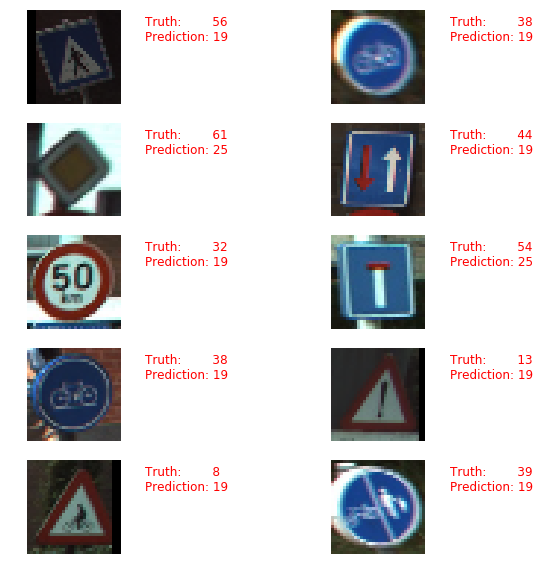

In [67]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])

    从上图我们可以发现，模型是可以正确运行的，但是从图中不能量化它的准确性。你可能已经注意到了我们分类的还是训练的图片，所以我们还不知道，模型在未知数据集上面的效果如何。接下来，我们在测试集上面进行更好地评测。

## 评估

    为了验证模型的准确性，在每次的运行中，我们获得的正确率在 0.40~0.70 之间

In [68]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

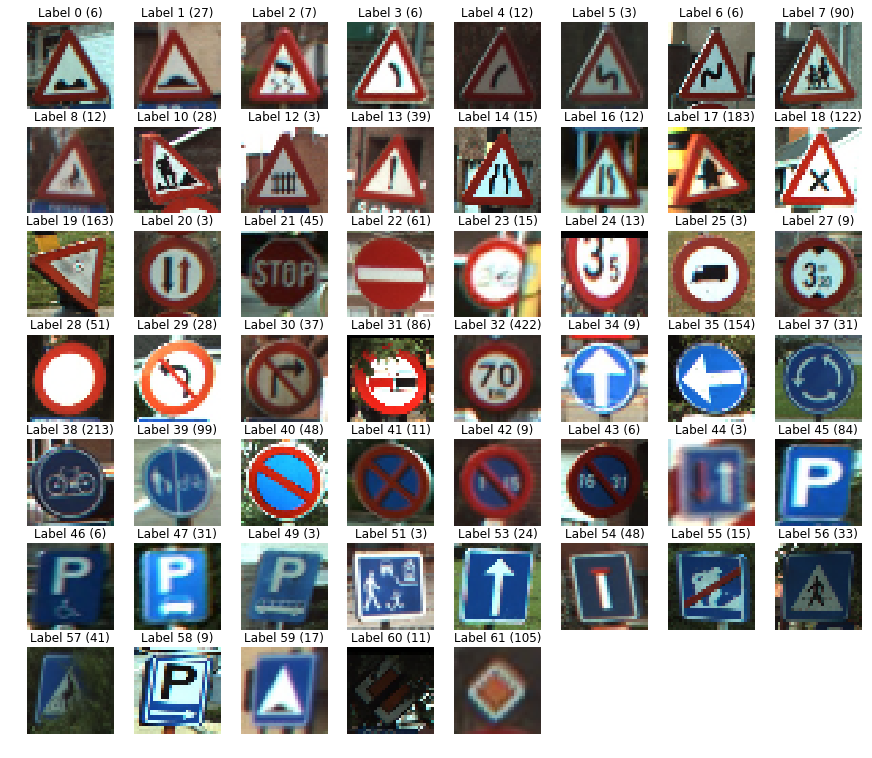

In [69]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

    这是评估部分的相关代码：

In [70]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.062


    在每次的运行中，我们获得的正确率在 0.40~0.70 之间

## 关闭会话

In [71]:
# Close the session. This will destroy the trained model.
session.close()